In [86]:
# system
import os
import random
from enum import Enum
from datetime import datetime, timedelta

# data processing and plotting
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import yfinance as yahooFinance

# ml/dl
from pmdarima import auto_arima, AutoARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

## Tools

In [87]:
def tm_btcusd_download_or_update(filename: str, instrument: str = 'BTC-USD', period: str = 'max', interval: str = '1d', saveToFile: bool = True, override: bool = False):
    """Updates BTCUSD price data up until today's datetime. Saves to csv.

    Args:
        filename (str): CSV filename
        instrument (str): what data to download. Defaults to BTC-USD.
        period (str): 1d, 5d, 1mo, 3mo, 6mo, 1y, 2y, 5y, 10y and ytd, max. Defaults to max.
        interval (str): 1m, 2m, 5m, 15m, 30m, 60m, 90m, 1h, 1d, 5d, 1wk, 1mo, 3mo. Defaults to 1d.
        saveToFile (bool): save the updated dataset to file. Defaults to True.
        override (bool): overrides file content with downloaded data. Defaults to True.
        
    Returns:
        pd.DataFrame: updated dataframe
    """
    # connect to yahoo and download data
    BTCUSDInfo = yahooFinance.Ticker(instrument)
    BTCUSDData = pd.DataFrame(BTCUSDInfo.history(period=period, interval=interval))
    
    """
        transform data
    """
    def tm_transform_data(df: pd.DataFrame) -> pd.DataFrame:
        # rename columns
        if not isinstance(df.index.name, str): df.index.name = 'date'
        df.columns = list(map(lambda x: x.lower(), df.columns))
        
        # convert date
        if 'date' in df.columns:
            # use data as index
            df.set_index('date', inplace=True)
            
        # convert
        df.index = pd.to_datetime(df.index)
        
        # remove tzinfo (time zone)
        df.index = list(map(lambda x: x.replace(tzinfo=None), pd.to_datetime(df.index)))
        df.index.name = 'date'
        
        return df
    
    # transform downloaded data
    BTCUSDData = tm_transform_data(BTCUSDData)

    # override data if needed and return
    if override:
        if saveToFile: BTCUSDData.to_csv(filename)
        return BTCUSDData
    
    # read old dataset and update data
    df_new = None
    if os.path.exists(filename):
        # read into memory
        df = pd.read_csv(filename, index_col=0)
        
        # transform old data
        df = tm_transform_data(df)
        
        # update data up to today's datetime
        timediff = (BTCUSDData.index[-1:] - df.index[-1])
        if timediff.total_seconds() > 0:
            df_new = pd.concat([df, BTCUSDData.iloc[df.shape[0]:]])
        else:
            df_new = df
    else:
        df_new = BTCUSDData
    
    # save to file if needed
    if saveToFile:
        df_new.to_csv(filename)
        
    return df_new
    

def tm_plot_price_data(df_price: pd.DataFrame, title: str = None, detailed: bool = False, figsize: tuple[int, int] = (7, 3)):
    # define figure
    plt.figure(figsize=figsize)
    plt.plot(df_price)

    # plot data
    plt.grid(c = 'gray', ls = '--', lw=0.4)
    if detailed:
        statdata = {
            'mean': (df_price.mean(), 'r'), 
            'median': (df_price.median(), 'g'),
        }
        
        # plot statdata
        for key, value in statdata.items():
            plt.text(x=df_price.index[0], y=value[0], s=key)
            plt.axhline(y=value[0], c=value[1], lw='0.7')

    # add info
    if title: plt.title(title)
    plt.ylabel('price')
    plt.xlabel('time')

    # plot
    plt.show()


def tm_plot_pred_vs_data(predictions: pd.DataFrame, true_data: pd.DataFrame, df_logs: pd.DataFrame = None, figsize: tuple[int, int] = (7, 3), xsize: int = 7):
    residuals = true_data - predictions
    
    # plot residuals
    plt.figure(figsize=figsize)
    plt.plot(residuals)
    plt.title('Residuals from AR Model')
    plt.ylabel('Error')
    plt.axhline(0, color='r', linestyle='--', alpha=0.2)
    plt.xticks(size=xsize)
    plt.show()

    # plot predictions vs true data
    plt.figure(figsize=figsize)
    plt.plot(true_data)
    plt.plot(predictions)
    if df_logs is not None:
        for i, idx in enumerate(df_logs.index):
            if df_logs.action[i].value == -1:
                plt.axvline(x=idx.to_pydatetime(), color='r')
            elif df_logs.action[i].value == 1:
                plt.axvline(x=idx.to_pydatetime(), color='b')
            else:
                plt.axvline(x=idx.to_pydatetime(), color='gray')
    plt.legend(('Data', 'Predictions'))
    plt.title('Predicted vs true data')
    plt.ylabel('data')
    plt.xticks(size=xsize)
    plt.show()
    
    
# appends row to time series dataframe (assumes date is used as index)
def df_append_row(df: pd.DataFrame, value: pd.Series):
    return pd.concat([
        df, 
        pd.DataFrame({df.index.name: value.index, df.columns[0]: value[0]}, index=[0]).set_index(df.index.name)
    ])
    

# appends row to time series dataframe (assumes date is used as index)
def df_append_row_ex(df: pd.DataFrame, index: pd.Timestamp, value: float):
    return pd.concat([
        df, 
        pd.DataFrame({df.index.name: index, df.columns[0]: value}, index=[0]).set_index(df.index.name)
    ])


# runs the training process (unsupervised, without correcting for true value, using its predicted value for training)
def run_training_unsupervised(df_train: pd.DataFrame) -> pd.DataFrame:
    # train the model
    model = AutoARIMA(
        trace=False, 
        error_action='ignore', 
        suppress_warnings=True
    ).fit(y=df_train, x=df_train)
    
    # predict
    y_pred = model.predict(n_periods=1)
    
    # add it to the training dataset
    df_train = df_append_row(df_train, y_pred)
    
    return df_train


# runs the training process (supervised, correcting for true value and using its true value for training)
def run_training_supervised(df_train: pd.DataFrame, n_periods: int = 1) -> tuple[pd.DataFrame, pd.Series]:
    # train the model
    model = AutoARIMA(
        trace=False, 
        error_action='ignore', 
        suppress_warnings=True
    ).fit(y=df_train, x=df_train)
    
    # predict
    y_pred = model.predict(n_periods=n_periods)
    
    return df_train, y_pred


class Strategies(Enum):
    """Trading Strategies."""
    NONE = 'none'
    RANDOM_CHOICE = "randomly select action, to buy/sell"
    AS_PREDICTED = "buy or sell as the model predicts"
    

class TradeAction(Enum):
    """Trading action."""
    NONE = 0
    BUY = 1
    SELL = -1
    

def run_simulation(
    df_sim_train: pd.DataFrame, 
    df_sim_true: pd.DataFrame, 
    strategyFunc,
    n_periods: int = 7, 
    balance: float = 500, 
    lots: float = 0.01, 
    verbose: bool = True,
    rolling_train_size: bool = False,
) -> tuple[pd.DataFrame, pd.DataFrame, float]:
    """Run ARIMA model simulation

    Args:
        df_sim_train (pd.DataFrame): training data
        df_sim_true (pd.DataFrame): true data
        strategyFunc (function): Trading strategy to use.
        n_periods (int, optional): Predict N periods after true data is exausted (nothing is traded during this period). Defaults to 7.
        balance (float, optional): Initial balance. Defaults to 500.
        lots (float, optional): Action lots per deal. Defaults to 0.01.
        verbose (bool, optional): Verbose output. Defaults to True.
        rolling_train_size (bool, optional): keep train size constant by rolling it forward. Defaults to False.
        
    Note:
        strategyFunc: `function(iter, df_sim_train, df_sim_true, df_predictions, trade_action, balance, lots) -> tuple[trade_action, balance]`

    Returns:
        tuple[pd.DataFrame, pd.DataFrame, float]: (predictions, trade_action_logs, balance)
    """
    # predicted list
    df_predictions = pd.DataFrame(columns=[df_sim_train.index.name, df_sim_train.columns[0]]).set_index(df_sim_train.index.name)
    
    # trade action
    df_trade_action_logs = pd.DataFrame(columns=[df_sim_train.index.name, 'action']).set_index(df_sim_train.index.name)
    
    # save initial balance value
    initial_balance = balance
    
    # track our trading action
    trade_action = TradeAction.NONE
        
    # iterations
    for i in range(df_sim_true.shape[0]+n_periods):
        if verbose: print(f'iteration {i:2d} | {df_sim_true.index[0]+timedelta(days=i)} | ', end='')
        
        # train the model and predict value for the next period
        # EX: today is X, we predict for today's closing price
        df_sim_train, y_pred = run_training_supervised(df_sim_train)

        # append to predictions
        df_predictions = df_append_row_ex(df_predictions, df_sim_true.iloc[i].name if i < df_sim_true.shape[0] else y_pred.index, y_pred[0])
        
        # update balance before next iteration
        initial_balance = balance
        
        # decide on trade action
        # EX: we decide what to do today based on the today's predicted closing price and past data
        trade_action, balance = strategyFunc(i, df_sim_train, df_sim_true, df_predictions, trade_action, balance, lots)
                
        # log trade action
        df_trade_action_logs = pd.concat([df_trade_action_logs, pd.DataFrame({df_predictions.index.name: [df_predictions.index[-1]], 'action': [trade_action]}).set_index(df_predictions.index.name)])
        
        # add true or predicted value to train dataset for the next training iteration
        df_sim_train = pd.concat([df_sim_train, df_sim_true.iloc[[i]] if i < df_sim_true.shape[0] else df_predictions.iloc[[-1]]])
        if rolling_train_size: df_sim_train = df_sim_train.iloc[1:]
        
        if verbose: 
            print(f'error {(((df_sim_true.iloc[i].values if i < df_sim_true.shape[0] else df_predictions.iloc[-1].values) - df_predictions.iloc[-1].values)/(df_sim_true.iloc[i].values if i < df_sim_true.shape[0] else df_predictions.iloc[-1].values))[0]:.2f}% | ', end='')
            print(f'balance {balance:.2f} | change {(100*(balance - initial_balance)/initial_balance):.2f}% | on next {trade_action}')
        
    return df_predictions, df_trade_action_logs, balance


def tm_plot_report(df_true: pd.DataFrame, df_predicted: pd.DataFrame, df_logs: pd.DataFrame = None, shifted: bool = False, figsize: tuple[int, int] = (7, 3), xsize: int = 7):
    # plot
    predicted = df_predicted.copy()
    # if shifted: predicted.index = predicted.index - timedelta(days=1)
    if shifted: predicted = predicted.shift(-1)
    tm_plot_pred_vs_data(predicted, df_true, df_logs, figsize=figsize, xsize=xsize)
    
    # calculate error
    mae = mean_absolute_error(df_true, predicted[(1 if shifted else 0):len(df_true) + (1 if shifted else 0)])
    rmse = np.sqrt(mean_squared_error(df_true, predicted[(1 if shifted else 0):len(df_true) + (1 if shifted else 0)]))
    print(f'Mean Absolute Error: {mae:.2f}')
    print(f'Root Mean Squared Error: {rmse:.2f}')

---

## Simulation

In [171]:
# download latest data and override
df = tm_btcusd_download_or_update('../data/btcusd.csv', override=False)
df.tail()

,open,high,low,close,volume,dividends,stock splits
date,,,,,,,
2024-02-04,42994.941406,43097.644531,42374.832031,42583.582031,14802225490,0.0,0.0
2024-02-05,42577.621094,43494.250000,42264.816406,42658.667969,18715487317,0.0,0.0
2024-02-06,42657.390625,43344.148438,42529.019531,43084.671875,16798476726,0.0,0.0
2024-02-07,43090.019531,44341.949219,42775.957031,44318.222656,21126587775,0.0,0.0
2024-02-08,44322.621094,45603.265625,44306.742188,45283.960938,15037764608,0.0,0.0


In [10]:
"""
    transform data
"""
def tm_transform_data(df: pd.DataFrame) -> pd.DataFrame:
    # rename columns
    df.columns = list(map(lambda x: x.lower(), df.columns))
    
    # convert date
    if 'date' in df.columns:
        # use data as index
        df.set_index('date', inplace=True)
        
    # convert
    df.index = pd.to_datetime(df.index)
    
    # remove tzinfo (time zone)
    df.index = list(map(lambda x: x.replace(tzinfo=None), pd.to_datetime(df.index)))
    df.index.name = 'date'
    
    return df
    
df = pd.read_csv('../data/btcusd.csv', index_col=0)
df = tm_transform_data(df)
df.tail()

,open,high,low,close,volume,dividends,stock splits
date,,,,,,,
2024-02-01,42558.761719,43290.671875,41840.511719,43097.660156,24546269184,0.0,0.0
2024-02-02,43077.640625,43422.488281,42584.335938,43185.859375,18603843039,0.0,0.0
2024-02-03,43184.964844,43359.941406,42890.808594,42992.250000,11169245236,0.0,0.0
2024-02-04,42983.964844,43094.941406,42253.808594,42602.250000,11169245236,0.0,0.0
2024-02-05,42577.621094,42597.265625,42268.742188,42373.960938,15037764608,0.0,0.0


In [24]:
df = df[:-1]
df.tail()

,open,high,low,close,volume,dividends,stock splits
date,,,,,,,
2024-01-31,42946.250000,43717.406250,42298.945312,42556.605469,24673628793,0.0,0.0
2024-02-01,42558.761719,43290.671875,41840.511719,43097.660156,24546269184,0.0,0.0
2024-02-02,43077.640625,43422.488281,42584.335938,43185.859375,18603843039,0.0,0.0
2024-02-03,43184.964844,43359.941406,42890.808594,42992.250000,11169245236,0.0,0.0
2024-02-04,42983.964844,43094.941406,42253.808594,42602.250000,11169245236,0.0,0.0


In [172]:
# define our strategy function: 1 day strategy
# buy if pred - yesterday > 0 else sell
def strategyFunc_as_predicted(i: int, df_sim_train: pd.DataFrame, df_sim_true: pd.DataFrame, df_predictions: pd.DataFrame, trade_action: TradeAction, balance: float, lots: float):
    # decide on action
    # EX: we have a predicton for today's closing price. Decide what to do today.
    trade_action = TradeAction.SELL if (df_predictions.iloc[-1].values - df_sim_train.iloc[-2].values)[0] < 0 else TradeAction.BUY
    
    # close the deal and adjust balance
    # EX: the day is over. Close the deal and adjust the balance
    balance = balance + lots * ((df_sim_true.iloc[i].values if i < df_sim_true.shape[0] else df_predictions.iloc[-1].values) - df_sim_train.iloc[-1].values)[0] * trade_action.value
    
    return trade_action, balance


# define our strategy function: 1 day strategy
# buy if pred - yesterday > 0 else sell :: only if change is small < 100%
def strategyFunc_as_predicted_extra_careful(i: int, df_sim_train: pd.DataFrame, df_sim_true: pd.DataFrame, df_predictions: pd.DataFrame, trade_action: TradeAction, balance: float, lots: float):
    # decide on action
    # EX: we have a predicton for today's closing price. Decide what to do today.
    delta = 0.005
    if (df_predictions.iloc[-1].values - df_sim_train.iloc[-2].values)[0] < 0 and np.abs((df_predictions.iloc[-1].values - df_sim_train.iloc[-2].values)[0]) < delta*df_sim_train.iloc[-1].values[0]:
        trade_action = TradeAction.SELL
    elif (df_predictions.iloc[-1].values - df_sim_train.iloc[-2].values)[0] > 0 and np.abs((df_predictions.iloc[-1].values - df_sim_train.iloc[-2].values)[0]) < delta*df_sim_train.iloc[-1].values[0]:
        trade_action = TradeAction.BUY
    else:
        trade_action = TradeAction.NONE
    
    # close the deal and adjust balance
    # EX: the day is over. Close the deal and adjust the balance
    balance = balance + lots * ((df_sim_true.iloc[i].values if i < df_sim_true.shape[0] else df_predictions.iloc[-1].values) - df_sim_train.iloc[-1].values)[0] * trade_action.value
    
    return trade_action, balance


# define our strategy function: 2 contiguous day strategy
# buy if pred - yesterday > 0 and yesterday - yesterday-1 > 0, sell if pred - yesterday < 0 and yesterday - yesterday-1 < 0 
def strategyFunc_as_predicted_p2cday(i: int, df_sim_train: pd.DataFrame, df_sim_true: pd.DataFrame, df_predictions: pd.DataFrame, trade_action: TradeAction, balance: float, lots: float):
    # decide on action
    # EX: we have a predicton for today's closing price. Decide what to do today.
    trade_action = TradeAction.SELL if (df_predictions.iloc[-1].values - df_sim_train.iloc[-2].values)[0] < 0 and (df_sim_train.iloc[-1].values - df_sim_train.iloc[-2].values)[0] < 0 else TradeAction.NONE
    trade_action = TradeAction.BUY if (df_predictions.iloc[-1].values - df_sim_train.iloc[-2].values)[0] > 0 and (df_sim_train.iloc[-1].values - df_sim_train.iloc[-2].values)[0] > 0 else trade_action
    
    # close the deal and adjust balance
    # EX: the day is over. Close the deal and adjust the balance
    balance = balance + lots * ((df_sim_true.iloc[i].values if i < df_sim_true.shape[0] else df_predictions.iloc[-1].values) - df_sim_train.iloc[-1].values)[0] * trade_action.value
    
    return trade_action, balance

In [178]:
# simulation variables
lots = 0.01
balance = 500
n_periods = 3
backtest_size = 30
train_size_ndays = 180

In [179]:
dfs = df[df.index[-1] - timedelta(days=train_size_ndays):]
dfs.head()

,open,high,low,close,volume,dividends,stock splits
date,,,,,,,
2023-08-12,29399.787109,29465.113281,29357.587891,29415.964844,6194358008,0.0,0.0
2023-08-13,29416.593750,29441.433594,29265.806641,29282.914062,7329897180,0.0,0.0
2023-08-14,29283.263672,29660.253906,29124.105469,29408.443359,14013695304,0.0,0.0
2023-08-15,29408.048828,29439.121094,29088.853516,29170.347656,12640195779,0.0,0.0
2023-08-16,29169.074219,29221.976562,28701.779297,28701.779297,14949271904,0.0,0.0


In [180]:
# split into train and test data
start_date, end_date = dfs.index[0], dfs.index[-1] - timedelta(days=backtest_size)
df_train = dfs[:end_date-timedelta(days=1)]
df_true = dfs[end_date:]

# transform data
df_sim_train = df_train.close.reset_index().set_index('date')
df_sim_true = df_true.close.reset_index().set_index('date')

# run simulation
df_predictions, df_logs, _ = run_simulation(
    df_sim_train=df_sim_train, 
    df_sim_true=df_sim_true, 
    strategyFunc=strategyFunc_as_predicted_extra_careful,
    n_periods=n_periods,
    balance=balance,
    lots=lots,
    verbose=True,
    rolling_train_size=True,
)

iteration  0 | 2024-01-09 00:00:00 | error -0.02% | balance 500.00 | change 0.00% | on next TradeAction.NONE
iteration  1 | 2024-01-10 00:00:00 | error 0.01% | balance 500.00 | change 0.00% | on next TradeAction.NONE
iteration  2 | 2024-01-11 00:00:00 | error -0.01% | balance 500.00 | change 0.00% | on next TradeAction.NONE
iteration  3 | 2024-01-12 00:00:00 | error -0.08% | balance 535.15 | change 7.03% | on next TradeAction.SELL
iteration  4 | 2024-01-13 00:00:00 | error -0.02% | balance 535.15 | change 0.00% | on next TradeAction.NONE
iteration  5 | 2024-01-14 00:00:00 | error -0.03% | balance 524.69 | change -1.95% | on next TradeAction.BUY
iteration  6 | 2024-01-15 00:00:00 | error 0.01% | balance 524.69 | change 0.00% | on next TradeAction.NONE
iteration  7 | 2024-01-16 00:00:00 | error 0.01% | balance 524.69 | change 0.00% | on next TradeAction.NONE
iteration  8 | 2024-01-17 00:00:00 | error -0.01% | balance 524.69 | change 0.00% | on next TradeAction.NONE
iteration  9 | 2024-01

In [181]:
# split into train and test data
start_date, end_date = dfs.index[0], dfs.index[-1] - timedelta(days=backtest_size)
df_train = dfs[:end_date-timedelta(days=1)]
df_true = dfs[end_date:]

# transform data
df_sim_train = df_train.close.reset_index().set_index('date')
df_sim_true = df_true.close.reset_index().set_index('date')

# run simulation
df_predictions, df_logs, _ = run_simulation(
    df_sim_train=df_sim_train, 
    df_sim_true=df_sim_true, 
    strategyFunc=strategyFunc_as_predicted,
    n_periods=n_periods,
    balance=balance,
    lots=lots,
    verbose=True,
    rolling_train_size=True,
)

iteration  0 | 2024-01-09 00:00:00 | error -0.02% | balance 491.69 | change -1.66% | on next TradeAction.BUY
iteration  1 | 2024-01-10 00:00:00 | error 0.01% | balance 486.81 | change -0.99% | on next TradeAction.SELL
iteration  2 | 2024-01-11 00:00:00 | error -0.01% | balance 484.22 | change -0.53% | on next TradeAction.BUY
iteration  3 | 2024-01-12 00:00:00 | error -0.08% | balance 519.37 | change 7.26% | on next TradeAction.SELL
iteration  4 | 2024-01-13 00:00:00 | error -0.02% | balance 519.48 | change 0.02% | on next TradeAction.SELL
iteration  5 | 2024-01-14 00:00:00 | error -0.03% | balance 509.02 | change -2.01% | on next TradeAction.BUY
iteration  6 | 2024-01-15 00:00:00 | error 0.01% | balance 501.86 | change -1.41% | on next TradeAction.SELL
iteration  7 | 2024-01-16 00:00:00 | error 0.01% | balance 508.29 | change 1.28% | on next TradeAction.BUY
iteration  8 | 2024-01-17 00:00:00 | error -0.01% | balance 504.17 | change -0.81% | on next TradeAction.BUY
iteration  9 | 2024-0

In [182]:
df_predictions[-7:].shift(-1)

,close
date,
2024-02-05,42771.171259
2024-02-06,43179.183033
2024-02-07,44446.783518
2024-02-08,45414.501992
2024-02-09,45543.268286
2024-02-10,45670.809189
2024-02-11,NaN


In [183]:
df_sim_true[-7:]

,close
date,
2024-02-02,43185.859375
2024-02-03,42992.250000
2024-02-04,42583.582031
2024-02-05,42658.667969
2024-02-06,43084.671875
2024-02-07,44318.222656
2024-02-08,45283.960938


In [184]:
# true
df_t = df_sim_true[-7:]
df_t.columns = ['close_t']

# predicted
df_p = df_predictions[-7:].shift(-1)
df_p.columns = ['close_p']

# combine
df_t.combine_first(df_p)

,close_p,close_t
date,,
2024-02-02,NaN,43185.859375
2024-02-03,NaN,42992.250000
2024-02-04,NaN,42583.582031
2024-02-05,42771.171259,42658.667969
2024-02-06,43179.183033,43084.671875
2024-02-07,44446.783518,44318.222656
2024-02-08,45414.501992,45283.960938
2024-02-09,45543.268286,NaN
2024-02-10,45670.809189,NaN


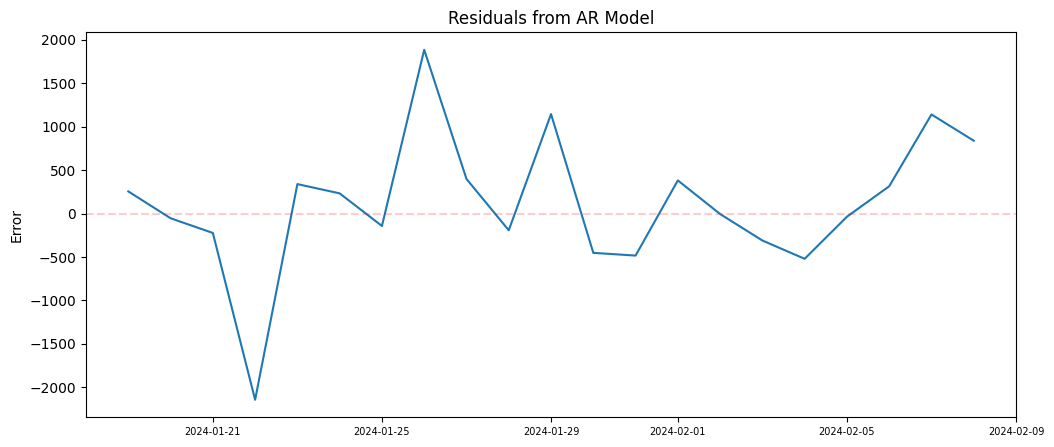

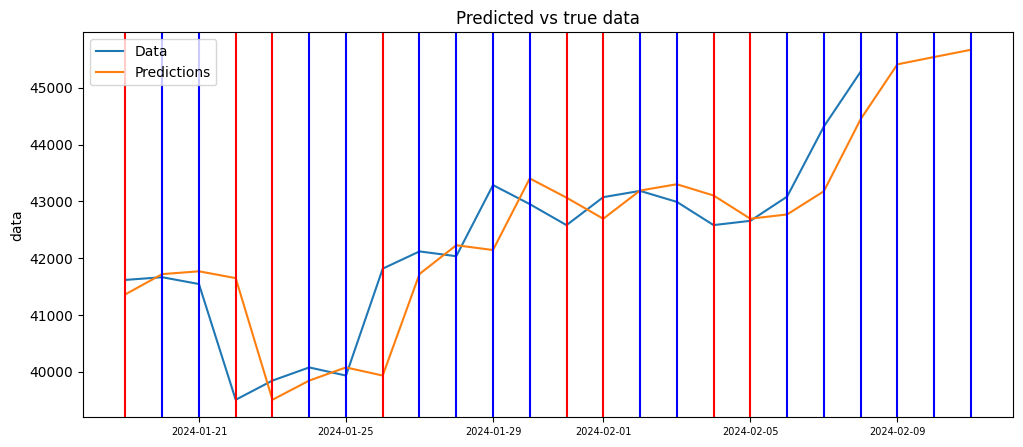

Mean Absolute Error: 546.99
Root Mean Squared Error: 786.65


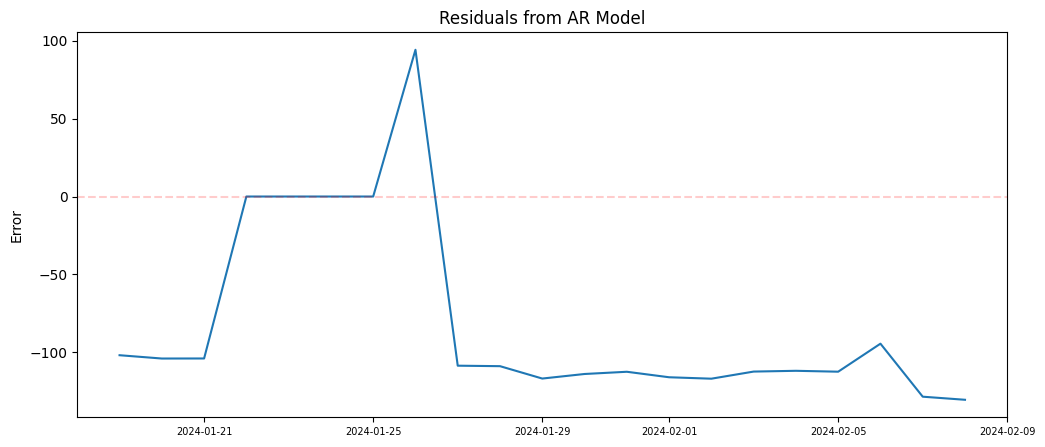

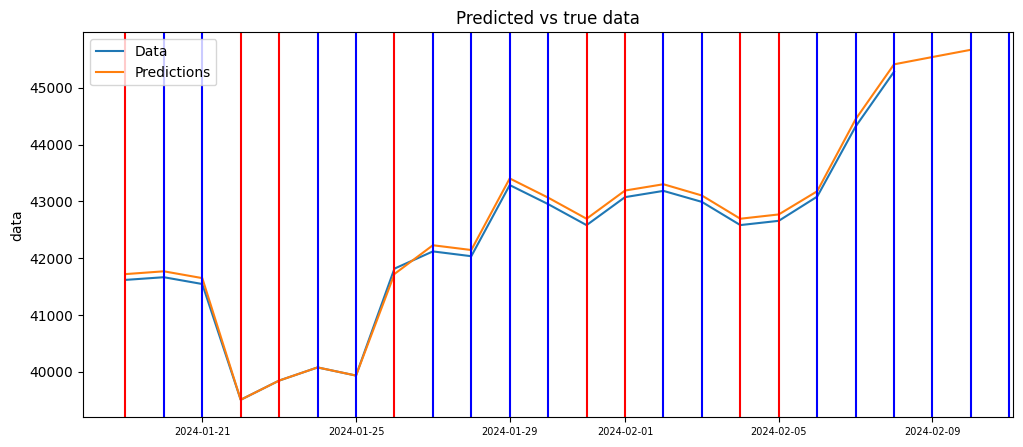

Mean Absolute Error: 553.92
Root Mean Squared Error: 806.99


In [185]:
tm_plot_report(df_sim_true[-21:], df_predictions[-24:], df_logs[-24:], figsize=(12, 5), xsize = 7)
tm_plot_report(df_sim_true[-21:], df_predictions[-24:], df_logs[-24:], figsize=(12, 5), xsize = 7, shifted=True)

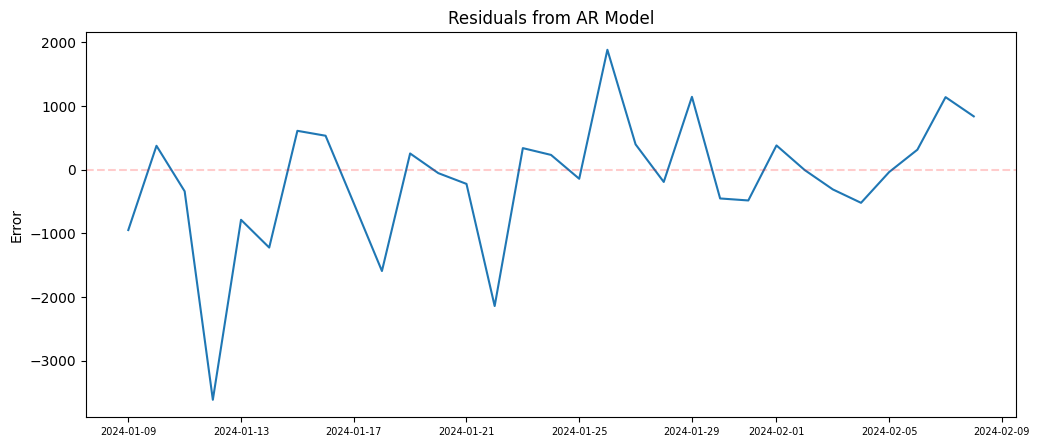

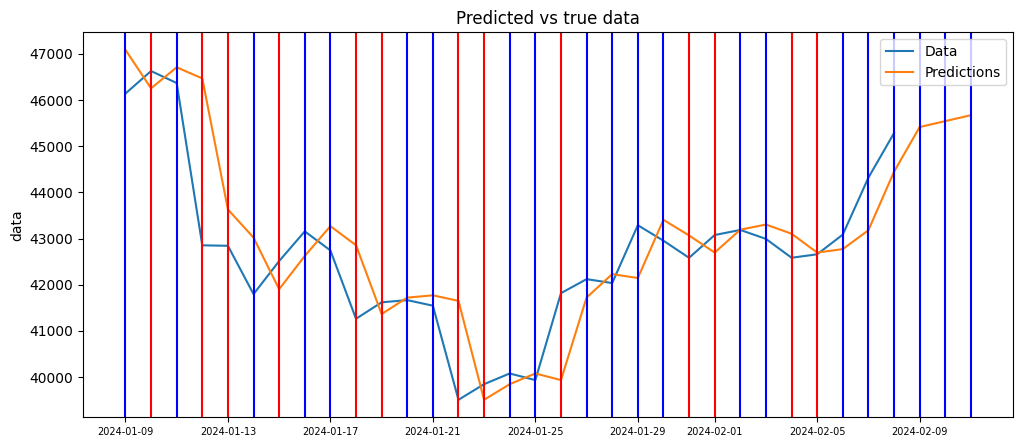

Mean Absolute Error: 710.91
Root Mean Squared Error: 1028.71


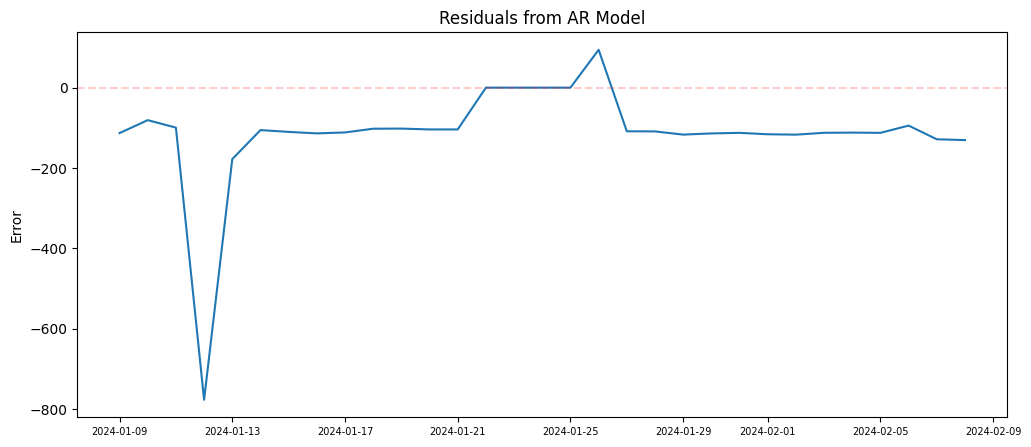

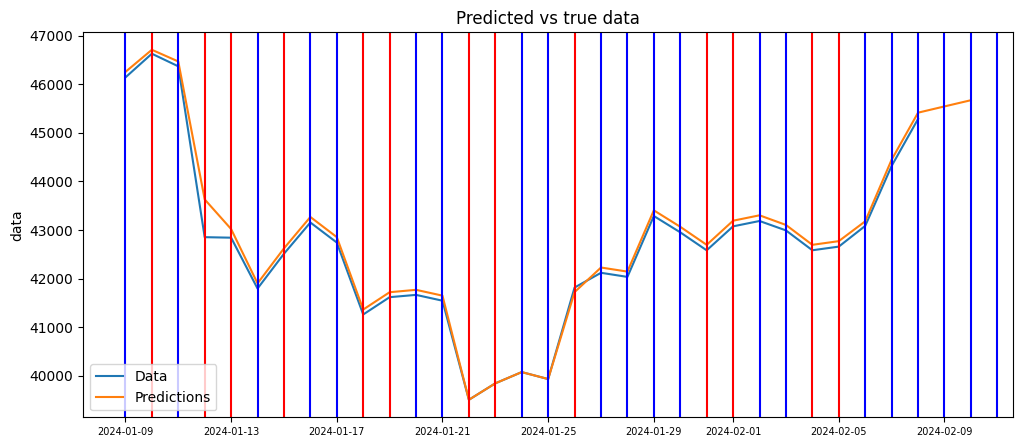

Mean Absolute Error: 642.81
Root Mean Squared Error: 913.90


In [186]:
tm_plot_report(df_sim_true, df_predictions, df_logs, figsize=(12, 5))
tm_plot_report(df_sim_true, df_predictions, df_logs, figsize=(12, 5), shifted=True)

---

## Simulation: 2 day prediction (nullifying the predicted shift) [IT IS WORSE]

In [148]:
def run_simulation_2dp(
    df_sim_train: pd.DataFrame, 
    df_sim_true: pd.DataFrame, 
    strategyFunc,
    n_periods: int = 7, 
    balance: float = 500, 
    lots: float = 0.01, 
    verbose: bool = True,
    rolling_train_size: bool = False,
) -> tuple[pd.DataFrame, pd.DataFrame, float]:
    """Run ARIMA model simulation

    Args:
        df_sim_train (pd.DataFrame): training data
        df_sim_true (pd.DataFrame): true data
        strategyFunc (function): Trading strategy to use.
        n_periods (int, optional): Predict N periods after true data is exausted (nothing is traded during this period). Defaults to 7.
        balance (float, optional): Initial balance. Defaults to 500.
        lots (float, optional): Action lots per deal. Defaults to 0.01.
        verbose (bool, optional): Verbose output. Defaults to True.
        rolling_train_size (bool, optional): keep train size constant by rolling it forward. Defaults to False.
        
    Note:
        strategyFunc: `function(iter, df_sim_train, df_sim_true, df_predictions, trade_action, balance, lots) -> tuple[trade_action, balance]`

    Returns:
        tuple[pd.DataFrame, pd.DataFrame, float]: (predictions, trade_action_logs, balance)
    """
    # predicted list
    df_predictions = pd.DataFrame(columns=[df_sim_train.index.name, df_sim_train.columns[0]]).set_index(df_sim_train.index.name)
    
    # trade action
    df_trade_action_logs = pd.DataFrame(columns=[df_sim_train.index.name, 'action']).set_index(df_sim_train.index.name)
    
    # save initial balance value
    initial_balance = balance
    
    # track our trading action
    trade_action = TradeAction.NONE
        
    # iterations
    for i in range(df_sim_true.shape[0]+n_periods):
        if verbose: print(f'iteration {i:2d} | {df_sim_true.index[0]+timedelta(days=i)} | ', end='')
        
        # train the model and predict value for the next period
        # EX: today is X, we predict for today's closing price
        df_sim_train, y_pred = run_training_supervised(df_sim_train, n_periods=2)
        
        # append to predictions
        df_predictions = df_append_row_ex(df_predictions, df_sim_true.iloc[i].name if i < df_sim_true.shape[0] else y_pred.index[0], y_pred[0])
        
        # update balance before next iteration
        initial_balance = balance
        
        # decide on trade action
        # EX: we decide what to do today based on the today's predicted closing price and past data
        trade_action, balance = strategyFunc(i, df_sim_train, df_sim_true, df_predictions, trade_action, balance, lots, y_pred)
                
        # log trade action
        df_trade_action_logs = pd.concat([df_trade_action_logs, pd.DataFrame({df_predictions.index.name: [df_predictions.index[-1]], 'action': [trade_action]}).set_index(df_predictions.index.name)])
        
        # add true or predicted value to train dataset for the next training iteration
        df_sim_train = pd.concat([df_sim_train, df_sim_true.iloc[[i]] if i < df_sim_true.shape[0] else df_predictions.iloc[[-1]]])
        if rolling_train_size: df_sim_train = df_sim_train.iloc[1:]
        
        if verbose: 
            print(f'error {(((df_sim_true.iloc[i].values if i < df_sim_true.shape[0] else df_predictions.iloc[-1].values) - df_predictions.iloc[-1].values)/(df_sim_true.iloc[i].values if i < df_sim_true.shape[0] else df_predictions.iloc[-1].values))[0]:.2f}% | ', end='')
            print(f'balance {balance:.2f} | change {(100*(balance - initial_balance)/initial_balance):.2f}% | on next {trade_action}')
        
    return df_predictions, df_trade_action_logs, balance

In [167]:
# define our strategy function: 1 day strategy
# buy if pred - yesterday > 0 else sell
def strategyFunc_2dp_as_predicted(i: int, df_sim_train: pd.DataFrame, df_sim_true: pd.DataFrame, df_predictions: pd.DataFrame, trade_action: TradeAction, balance: float, lots: float, pred2d: pd.Series):
    # decide on action
    # EX: we have a predicton for today's closing price. Decide what to do today.
    trade_action = TradeAction.SELL if (pred2d[-1] - df_sim_train.iloc[-2].values[0]) < 0 else TradeAction.BUY
    
    # close the deal and adjust balance
    # EX: the day is over. Close the deal and adjust the balance
    balance = balance + lots * ((df_sim_true.iloc[i].values if i < df_sim_true.shape[0] else pred2d[-1]) - df_sim_train.iloc[-1].values)[0] * trade_action.value
    
    return trade_action, balance


# define our strategy function: 1 day strategy
# buy if pred - yesterday > 0 else sell :: only if change is small < 100%
def strategyFunc_2dp_as_predicted_extra_careful(i: int, df_sim_train: pd.DataFrame, df_sim_true: pd.DataFrame, df_predictions: pd.DataFrame, trade_action: TradeAction, balance: float, lots: float, pred2d: pd.Series):
    # decide on action
    # EX: we have a predicton for today's closing price. Decide what to do today.
    delta = 0.005
    if (pred2d[-1] - df_sim_train.iloc[-1].values[0]) < 0 and np.abs((pred2d[-1] - df_sim_train.iloc[-1].values[0])) < delta*df_sim_train.iloc[-1].values[0]:
        trade_action = TradeAction.SELL
    elif (pred2d[-1] - df_sim_train.iloc[-1].values[0]) > 0 and np.abs((pred2d[-1] - df_sim_train.iloc[-1].values[0])) < delta*df_sim_train.iloc[-1].values[0]:
        trade_action = TradeAction.BUY
    else:
        trade_action = TradeAction.NONE
    
    # close the deal and adjust balance
    # EX: the day is over. Close the deal and adjust the balance
    balance = balance + lots * ((df_sim_true.iloc[i].values if i < df_sim_true.shape[0] else pred2d[-1]) - df_sim_train.iloc[-1].values)[0] * trade_action.value
    
    return trade_action, balance

In [168]:
# split into train and test data
start_date, end_date = dfs.index[0], dfs.index[-1] - timedelta(days=backtest_size)
df_train = dfs[:end_date-timedelta(days=1)]
df_true = dfs[end_date:]

# transform data
df_sim_train = df_train.close.reset_index().set_index('date')
df_sim_true = df_true.close.reset_index().set_index('date')

# run simulation
df_predictions, df_logs, _ = run_simulation_2dp(
    df_sim_train=df_sim_train, 
    df_sim_true=df_sim_true, 
    # strategyFunc=strategyFunc_2dp_as_predicted,
    strategyFunc=strategyFunc_2dp_as_predicted_extra_careful,
    n_periods=n_periods,
    balance=balance,
    lots=lots,
    verbose=True,
    rolling_train_size=True,
)

iteration  0 | 2024-01-14 00:00:00 | error -0.03% | balance 500.00 | change 0.00% | on next TradeAction.NONE
iteration  1 | 2024-01-15 00:00:00 | error 0.02% | balance 500.00 | change 0.00% | on next TradeAction.NONE
iteration  2 | 2024-01-16 00:00:00 | error 0.01% | balance 500.00 | change 0.00% | on next TradeAction.NONE
iteration  3 | 2024-01-17 00:00:00 | error -0.01% | balance 500.00 | change 0.00% | on next TradeAction.NONE
iteration  4 | 2024-01-18 00:00:00 | error -0.04% | balance 500.00 | change 0.00% | on next TradeAction.NONE
iteration  5 | 2024-01-19 00:00:00 | error -0.00% | balance 500.00 | change 0.00% | on next TradeAction.NONE
iteration  6 | 2024-01-20 00:00:00 | error -0.00% | balance 500.47 | change 0.09% | on next TradeAction.BUY
iteration  7 | 2024-01-21 00:00:00 | error -0.01% | balance 499.27 | change -0.24% | on next TradeAction.BUY
iteration  8 | 2024-01-22 00:00:00 | error -0.05% | balance 478.89 | change -4.08% | on next TradeAction.BUY
iteration  9 | 2024-01

In [138]:
df_predictions[-7:]

,close
date,
2024-02-04,43214.076134
2024-02-05,42818.165499
2024-02-06,42901.656351
2024-02-07,43286.561517
2024-02-08,44541.967112
2024-02-09,44784.402348
2024-02-10,45023.682439


In [139]:
df_sim_true[-7:]

,close
date,
2024-02-01,43097.660156
2024-02-02,43185.859375
2024-02-03,42992.250000
2024-02-04,42602.250000
2024-02-05,42685.960938
2024-02-06,43063.960938
2024-02-07,44302.960938


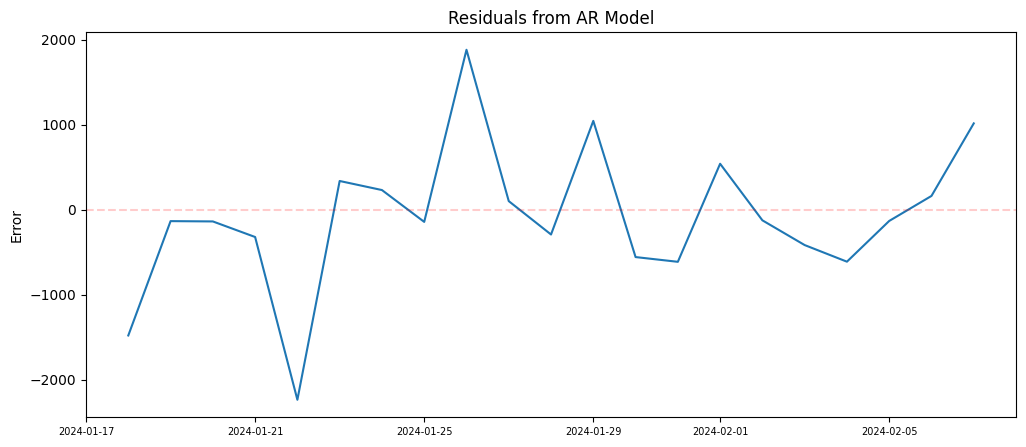

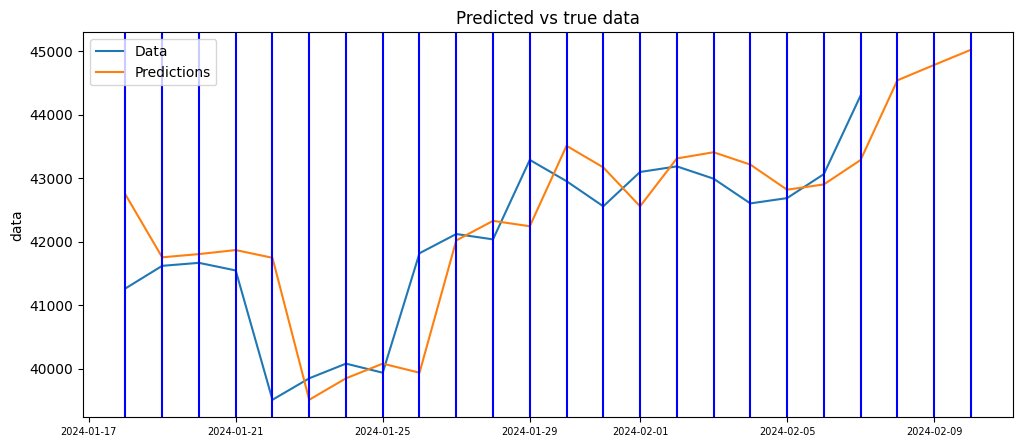

Mean Absolute Error: 596.33
Root Mean Squared Error: 841.87


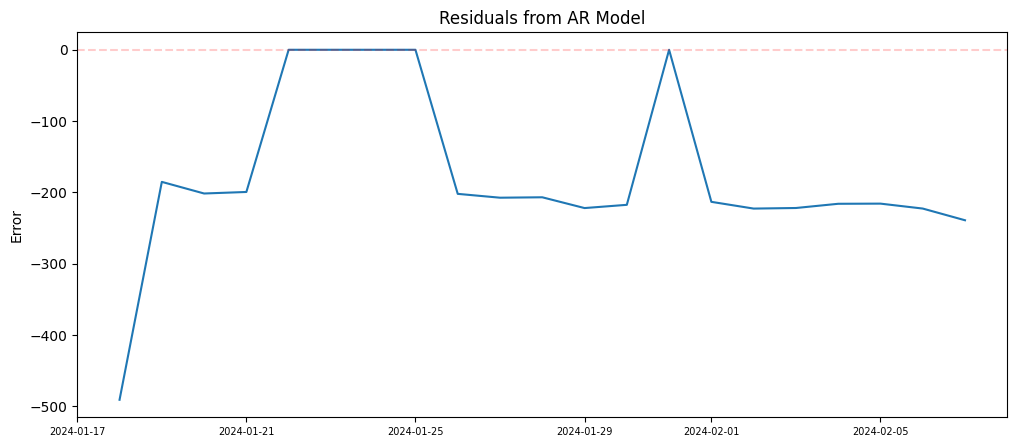

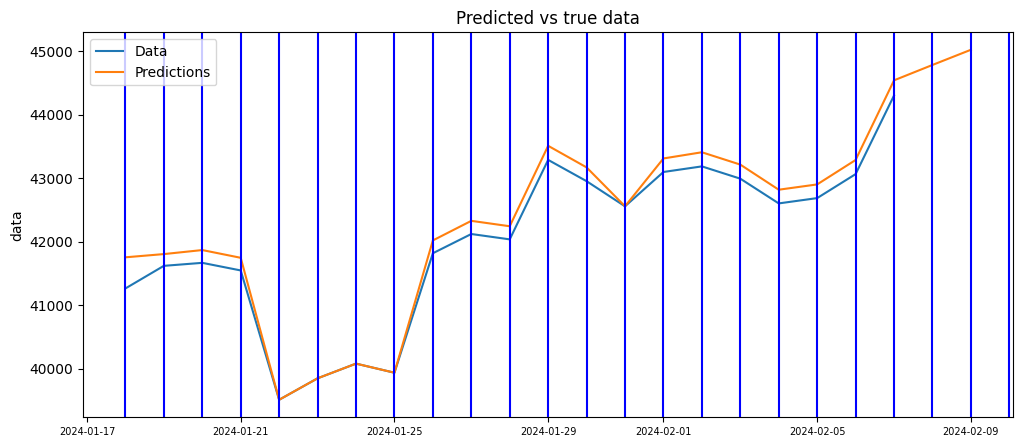

Mean Absolute Error: 593.09
Root Mean Squared Error: 851.79


In [140]:
tm_plot_report(df_sim_true[-21:], df_predictions[-24:], df_logs[-24:], figsize=(12, 5), xsize = 7)
tm_plot_report(df_sim_true[-21:], df_predictions[-24:], df_logs[-24:], figsize=(12, 5), xsize = 7, shifted=True)

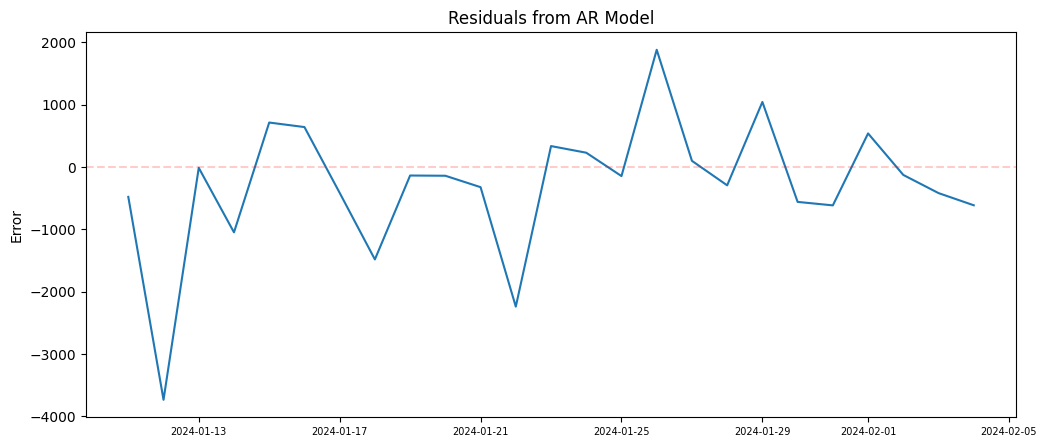

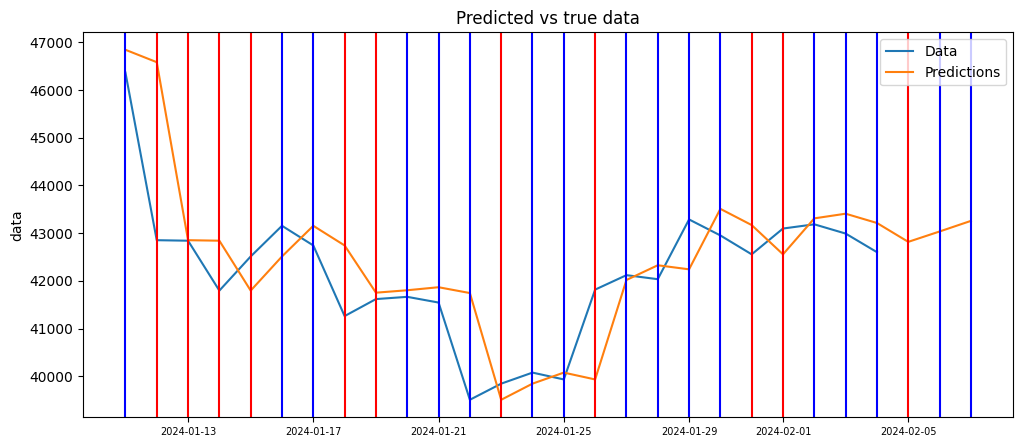

Mean Absolute Error: 729.96
Root Mean Squared Error: 1098.26


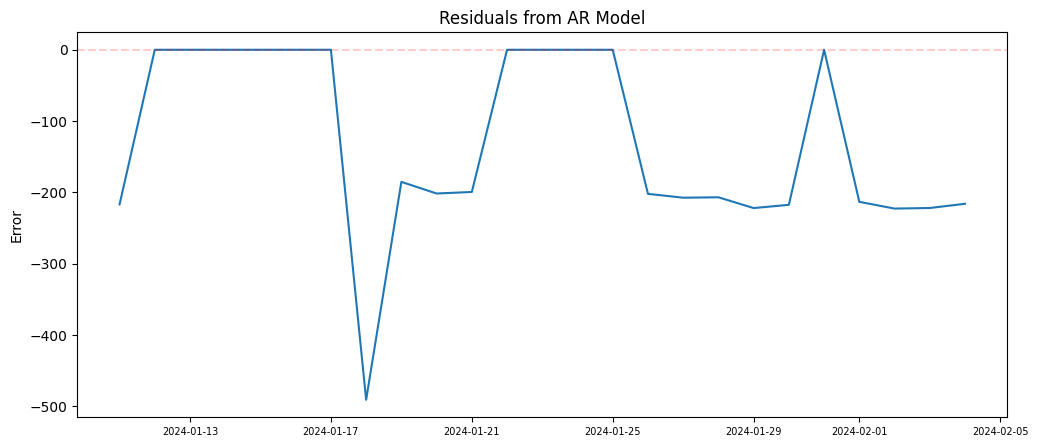

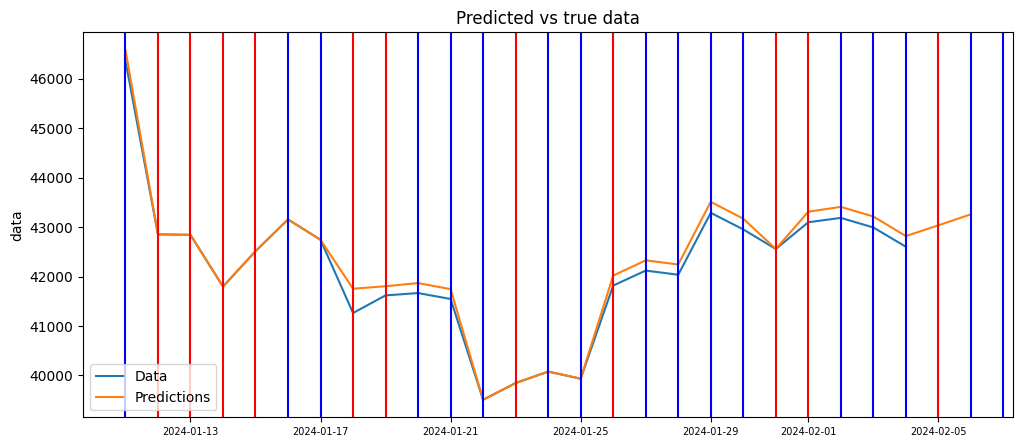

Mean Absolute Error: 694.47
Root Mean Squared Error: 1059.92


In [78]:
tm_plot_report(df_sim_true, df_predictions, df_logs, figsize=(12, 5))
tm_plot_report(df_sim_true, df_predictions, df_logs, figsize=(12, 5), shifted=True)